In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from skbio.diversity.alpha import shannon
from sklearn.metrics import pairwise_distances
from collections import Counter
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr,kendalltau
from scipy.cluster.hierarchy import leaves_list

# Load sample metadata and count table

In [2]:
# read sample meta data and eliminate samples without transplant day
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read count data
df_count_stacked = pd.read_csv('tblcounts_asv_melt.csv')
df_count_stacked = pd.pivot_table(df_count_stacked, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
df_count_stacked = df_count_stacked[df_count_stacked.sum(axis=1)>=1000]
df_count_stacked = df_count_stacked.loc[:, (df_count_stacked != 0).any(axis=0)]
print("min seq depth = %d" %(df_count_stacked.sum(axis=1).min()))
df_relab_asv =  df_count_stacked.div(df_count_stacked.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab_asv.index))
df_sample = df_sample.loc[common_samples]
df_relab_asv = df_relab_asv.loc[common_samples]

min seq depth = 1001


# Pairwise distance

In [3]:
# df_pdist_asv = pd.DataFrame(
#     pairwise_distances(df_relab_asv.values, metric="braycurtis", n_jobs=-1),
#     index=df_relab_asv.index,
#     columns=df_relab_asv.index)
# df_pdist_asv.to_csv("/Users/liaoc/Documents/MSKCC_braycurtis_distance.csv")

In [4]:
df_pdist_asv = pd.read_csv("/Users/liaoc/Documents/MSKCC_braycurtis_distance.csv", index_col=0)
df_pdist_asv.head()

,573C,1141E,1144B,1452A,1101R,488F,1865H,1648A,1390I,1119F,...,1842EE,720B,1865J,251B,1498C,FMT.0229B,1785A,FMT.0242F,FMT.0106S,1277O
SampleID,,,,,,,,,,,,,,,,,,,,,
573C,0.000000,0.833038,0.993191,0.976851,0.933052,0.770708,0.999160,0.859384,0.987743,0.935724,...,0.994170,0.982533,0.737731,0.932521,0.837945,0.869173,0.885756,0.903592,0.836724,0.868496
1141E,0.833038,0.000000,0.965973,0.983080,0.966232,0.727592,0.999168,0.895021,0.994605,0.977672,...,0.986658,0.875076,0.858381,0.965952,0.960213,0.896453,0.929005,0.923129,0.901715,0.883823
1144B,0.993191,0.965973,0.000000,0.995364,0.996190,0.994617,0.998934,0.950141,0.997203,0.994527,...,0.997220,0.994876,0.996291,0.996190,0.984260,0.995972,0.996190,0.996085,0.997710,0.992569
1452A,0.976851,0.983080,0.995364,0.000000,0.984422,0.986763,0.999328,0.974981,0.085268,0.990105,...,0.337849,0.993252,0.986532,0.951463,0.980613,0.992612,0.986193,0.980529,0.997235,0.982062
1101R,0.933052,0.966232,0.996190,0.984422,0.000000,0.982468,0.989040,0.833716,0.995507,0.995342,...,0.996406,0.999354,0.920463,0.139230,0.989057,0.993147,0.990251,0.975736,0.996953,0.961065


# Compute oral percentage and Shannon index

In [5]:
# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab_asv[set(df_blast_100.query_accver).intersection(df_relab_asv.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_oral_total = df_oral_total.reset_index('SampleID').sort_values(['OralFrac_HMPv35oral','SampleID']).set_index('SampleID')

# calculate shannon index
shannon_index = {}
for sample in df_relab_asv.index:
    shannon_index[sample] = shannon(df_relab_asv.loc[sample])
df_shannon = pd.DataFrame.from_dict(shannon_index, orient='index', columns=['Shannon']).reset_index().rename(columns={'index':'SampleID'}).set_index('SampleID')

# Load qPCR, taxonomy,neutrophil count

In [6]:
# read qPCR
df_qpcr = pd.read_csv('tblqpcr.csv', index_col=0)
df_qpcr = pd.merge(df_qpcr, df_sample, left_index=True, right_index=True, how='right')

# load neutrophils count
df_bc = pd.read_csv('tblbc.csv', low_memory=False)
df_bc = df_bc[df_bc.BloodCellType=='Neutrophils']
df_bc = pd.merge(df_bc[['PatientID','Timepoint','Value']], df_sample.reset_index(), left_on=['PatientID','Timepoint'], right_on=['PatientID','Timepoint'], how='right').set_index('SampleID').rename({'Value':'Count'}, axis=1)

# read taxonomy
df_tax = pd.read_csv('tblASVtaxonomy_silva138_v4v5_filter.csv', index_col=0)
df_tax = df_tax.loc[df_relab_asv.columns]
df_tax.index.name = 'ASV'

# Find dominant ASV of each sample

In [7]:
# find the ASV with highest relative abundance
df_dominant_asv = df_relab_asv.idxmax(axis=1).to_frame()
df_dominant_asv.columns = ['ASV']
df_dominant_asv.reset_index(inplace=True)

# append genus of the dominant asv
df_dominant_asv = pd.merge(df_dominant_asv, df_tax[['Genus']].reset_index(), left_on='ASV', right_on='ASV', how='left')

# find abundance of dominant ASVs
df_relab_asv_stack = df_relab_asv.stack().reset_index()
df_relab_asv_stack.columns = ['SampleID','ASV','Abundance']
df_dominant_asv = pd.merge(df_dominant_asv, df_relab_asv_stack, left_on=['SampleID','ASV'], right_on=['SampleID','ASV'], how='left')

# associate color to each taxa that will be labelled
genus2label = ['Enterococcus','Streptococcus','Lactobacillus','[Clostridium] innocuum group',
               'Erysipelatoclostridium','Akkermansia','Blautia','Bifidobacterium','Escherichia-Shigella',
               'Staphylococcus','Klebsiella','Bacteroides','Actinomyces','Veillonella','Abiotrophia']
genus_color = {}
for g in genus2label:
    df_tmp = df_dominant_asv[(df_dominant_asv.Genus==g)&(df_dominant_asv.Abundance>=0.3)]
    representative_asv = pd.DataFrame.from_dict(dict(Counter(df_tmp.ASV)), orient='index').rename({0:'Count'},axis=1).sort_values('Count', ascending=False).index[0]
    genus_color[g] = df_tax.loc[representative_asv, 'TaxonomyColor']
                                                     
# append color to dominant asvs
df_dominant_asv['BarColor'] = [genus_color[g] if g in genus_color.keys() else '#ffffff' for g in df_dominant_asv.Genus]

df_dominant_asv.head()

,SampleID,ASV,Genus,Abundance,BarColor
0,1428Y,ASV_2,Enterococcus,0.759515,#006026
1,1392O,ASV_2,Enterococcus,0.470327,#006026
2,943E,ASV_1390,Lactobacillus,0.770831,#708DF4
3,1217T,ASV_2,Enterococcus,0.805615,#006026
4,698G,ASV_6,Erysipelatoclostridium,0.780470,#ED9017


# Compute relative abundance of each color

In [8]:
unique_color = df_tax[['TaxonomyColor','TaxonomyColorOrder']].drop_duplicates().sort_values(by='TaxonomyColorOrder').reset_index(drop=True)
relab_asv_grouped = np.zeros((len(df_relab_asv.index),len(unique_color.index)))
for k,o in enumerate(unique_color.TaxonomyColorOrder):
    relab_asv_grouped[:,k] = df_relab_asv[set(df_relab_asv.columns).intersection(set(df_tax[df_tax.TaxonomyColorOrder==o].index))].sum(axis=1).values
df_relab_asv_grouped = pd.DataFrame(relab_asv_grouped, index=df_relab_asv.index, columns=unique_color.TaxonomyColor)
df_relab_asv_grouped = df_relab_asv_grouped.loc[df_oral_total.index]
df_relab_asv_grouped.head()

TaxonomyColor,#D6BDAD,#685C54,#9F8D81,#BBA597,#84746A,#C8B1A2,#AD998C,#918075,#76685F,#CFB7A7,...,#E62727,#DC2020,#D21818,#C81212,#BE0B0B,#B40404,#FD3636,#F83333,#F32F2F,#EE2C2C
SampleID,,,,,,,,,,,,,,,,,,,,,
1001,0.007465,0.042613,0.018974,0.000000,0.000000,0.224883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006221
1002,0.009937,0.012647,0.039747,0.000000,0.000000,0.224932,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
103A,0.028754,0.010650,0.001065,0.105964,0.009585,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Find number of samples that have oral-ASV dominations

In [9]:
df_relab_asv_oral = (df_relab_asv[[x for x in df_relab_asv.columns if x in list(df_blast_100.query_accver)]]>0.3).astype(int)
len(df_relab_asv_oral.sum(axis=1)[df_relab_asv_oral.sum(axis=1)>0])

901

In [10]:
Counter(df_relab_asv_oral.stack().reset_index()[df_relab_asv_oral.stack().reset_index()[0]==1].ASV)

Counter({'ASV_8': 697,
         'ASV_51': 40,
         'ASV_202': 3,
         'ASV_32': 61,
         'ASV_342': 13,
         'ASV_472': 30,
         'ASV_128': 33,
         'ASV_635': 16,
         'ASV_150': 1,
         'ASV_175': 7,
         'ASV_2883': 3,
         'ASV_4495': 2,
         'ASV_264': 2,
         'ASV_2646': 2,
         'ASV_207': 1,
         'ASV_6283': 1,
         'ASV_2751': 3,
         'ASV_616': 1,
         'ASV_2426': 1,
         'ASV_229': 1,
         'ASV_2720': 1,
         'ASV_2032': 1})

In [11]:
df_tax.loc[dict(Counter(df_relab_asv_oral.stack().reset_index()[df_relab_asv_oral.stack().reset_index()[0]==1].ASV)).keys(),'LowestClassifiedTaxa']

ASV
ASV_8        Streptococcus
ASV_51         Actinomyces
ASV_202      Streptococcus
ASV_32       Streptococcus
ASV_342      Streptococcus
ASV_472        Abiotrophia
ASV_128        Actinomyces
ASV_635     Granulicatella
ASV_150            Gemella
ASV_175      Streptococcus
ASV_2883     Fusobacterium
ASV_4495      Leptotrichia
ASV_264        Veillonella
ASV_2646        Prevotella
ASV_207      Fusobacterium
ASV_6283        Prevotella
ASV_2751      Leptotrichia
ASV_616         Parvimonas
ASV_2426      Leptotrichia
ASV_229             Rothia
ASV_2720        Prevotella
ASV_2032       Haemophilus
Name: LowestClassifiedTaxa, dtype: object

# Number of samples

In [12]:
print("total # = %d, sampels >50 = %d, samples >30 = %d, samples >10 = %d, patients = %d" % (len(df_oral_total), 
                                                           len(df_oral_total[df_oral_total.OralFrac_HMPv35oral>0.5]), 
                                                           len(df_oral_total[df_oral_total.OralFrac_HMPv35oral>0.3]),
                                                           len(df_oral_total[df_oral_total.OralFrac_HMPv35oral>0.1]),                                  
                                                           len(set(df_sample.loc[df_oral_total.index].PatientID))
                                                                          ))

total # = 10433, sampels >50 = 792, samples >30 = 1389, samples >10 = 3342, patients = 1276


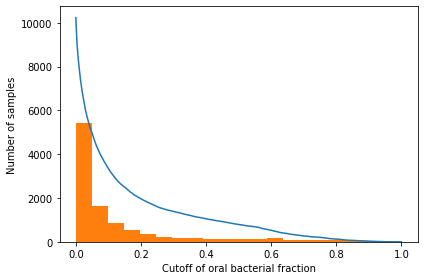

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), sharex=True)

res = []
for c in np.linspace(0,1,1001):
    res.append([c,len(df_oral_total[df_oral_total.OralFrac_HMPv35oral>c])])
df_res = pd.DataFrame(res, columns=['Cutoff','Number'])

_ = ax.plot(df_res.Cutoff, df_res.Number)
_ = ax.set_xlabel('Cutoff of oral bacterial fraction')
_ = ax.set_ylabel('Number of samples')
_ = ax.hist(df_oral_total.OralFrac_HMPv35oral, bins=20)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("number_of_samples_above_oral_bacterial_cutoff.svg")

In [14]:
# number of qPCR samples
len(df_qpcr.loc[df_oral_total.index][df_qpcr.loc[df_oral_total.index].qPCR16S.notnull()])

3126

# Plot

In [18]:
# number of qPCR samples
Y = sch.linkage(squareform(df_pdist_asv.loc[df_oral_total.index,df_oral_total.index].values), method='average')
df_qpcr_reordered = df_qpcr.loc[df_oral_total.index].iloc[leaves_list(Y)]
len(df_qpcr_reordered[df_qpcr_reordered.qPCR16S.notnull()])

3126

In [36]:
%%capture

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(30,10))

# we do not need to plot all samples during code development
# set n_samples_to_plot a small number
n_samples_to_plot = int(1e10)
total_sample_number = len(df_relab_asv_grouped)

# find clusters
Y = sch.linkage(squareform(df_pdist_asv.loc[df_oral_total.index,df_oral_total.index].values), method='average')

# plot stacked bars of oral bacterial fraction
_ = df_oral_total.iloc[leaves_list(Y)].iloc[0:np.min([n_samples_to_plot, total_sample_number])].OralFrac_HMPv35oral.plot.bar(
    color=(0.4980392156862745, 0.4980392156862745, 0.4980392156862745), 
    legend=None, 
    width=1.0, 
    ax=ax[0], 
    ylim=[0,1]
)
_ = ax[0].set_ylabel('')
_ = ax[0].set_yticks([])
_ = ax[0].set_yticks([], minor=True)
_ = ax[0].set_xlabel('')
_ = ax[0].set_xticks([])
_ = ax[0].set_xticks([], minor=True)

# plot stacked bars of microbiota composition
df_relab_asv_grouped_reordered = df_relab_asv_grouped.loc[df_oral_total.index].iloc[leaves_list(Y)]
_ = df_relab_asv_grouped_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].plot.bar(
    stacked=True, 
    color=df_relab_asv_grouped_reordered.columns, 
    legend=None, 
    width=1.0, 
    ax=ax[1], 
    ylim=[0,1]
)
_ = ax[1].set_ylabel('')
_ = ax[1].set_yticks([])
_ = ax[1].set_yticks([], minor=True)
_ = ax[1].set_xlabel('')
_ = ax[1].set_xticks([])
_ = ax[1].set_xticks([], minor=True)
    
# plot most abundant ASV
df_dominant_asv_reordered = df_dominant_asv.set_index('SampleID').loc[df_oral_total.index].iloc[leaves_list(Y)]
df_dominant_asv_reordered['Value'] = 1
_ = df_dominant_asv_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].Value.plot.bar(
    stacked=True,
    color=df_dominant_asv_reordered.BarColor,
    legend=None,
    width=1.0,
    ax=ax[2],
    ylim=[0,1]
)
_ = ax[2].set_ylabel('')
_ = ax[2].set_yticks([])
_ = ax[2].set_yticks([], minor=True)
_ = ax[2].set_xlabel('')
_ = ax[2].set_xticks([])
_ = ax[2].set_xticks([], minor=True)
       
# plot shannon index
df_shannon_reordered = df_shannon.loc[df_oral_total.index].iloc[leaves_list(Y)]
df_shannon_reordered['Value'] = 1
df_shannon_reordered['BarColor'] = 'dodgerblue'
df_shannon_reordered.loc[df_shannon_reordered.Shannon>=4, 'BarColor'] = 'orangered'
_ = df_shannon_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].Value.plot.bar(
    stacked=True,
    color=df_shannon_reordered.BarColor,
    legend=None,
    width=1.0,
    ax=ax[3],
    ylim=[0,1]
)
_ = ax[3].set_ylabel('')
_ = ax[3].set_yticks([])
_ = ax[3].set_yticks([], minor=True)
_ = ax[3].set_xlabel('')
_ = ax[3].set_xticks([])
_ = ax[3].set_xticks([], minor=True)
    
# plot HCT day of samples based on whether antibiotics were heavily administered
# since samples without transplant day have been removed, there are no missing value for HCT day
df_sample_reordered = df_sample.loc[df_oral_total.index].iloc[leaves_list(Y)]
df_sample_reordered['Value'] = 1
df_sample_reordered.loc[(df_sample_reordered.DayRelativeToNearestHCT>=-10)&(df_sample_reordered.DayRelativeToNearestHCT<=40),'BarColor'] = '#ffe873'
df_sample_reordered.loc[(df_sample_reordered.DayRelativeToNearestHCT<-10),'BarColor'] = 'dodgerblue'
df_sample_reordered.loc[(df_sample_reordered.DayRelativeToNearestHCT>40),'BarColor'] = 'orangered'
_ = df_sample_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].Value.plot.bar(
    stacked=False,
    color=df_sample_reordered.BarColor,
    legend=None, 
    width=1.0, 
    ax=ax[4], 
    ylim=[0,1]
)
_ = ax[4].set_ylabel('')
_ = ax[4].set_yticks([])
_ = ax[4].set_yticks([], minor=True)
_ = ax[4].set_xlabel('')
_ = ax[4].set_xticks([])
_ = ax[4].set_xticks([], minor=True)
        
# plot qPCR
df_qpcr_reordered = df_qpcr.loc[df_oral_total.index].iloc[leaves_list(Y)]
df_qpcr_reordered['Value'] = 1
df_qpcr_reordered['BarColor'] = 'lightgrey'
df_qpcr_reordered.loc[df_qpcr_reordered.qPCR16S>=1e7,'BarColor'] = 'orangered'
df_qpcr_reordered.loc[df_qpcr_reordered.qPCR16S<1e7,'BarColor'] = 'dodgerblue'
_ = df_qpcr_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].Value.plot.bar(
    stacked=False,
    color=df_qpcr_reordered.BarColor,
    legend=None, 
    width=1.0, 
    ax=ax[5],
    ylim=[0,1]
)
_ = ax[5].set_ylabel('')
_ = ax[5].set_yticks([])
_ = ax[5].set_yticks([], minor=True)
_ = ax[5].set_xlabel('')
_ = ax[5].set_xticks([])
_ = ax[5].set_xticks([], minor=True)

# plot neutrophil count (if neutrophil count >= 0.5)
df_bc_reordered = df_bc.loc[df_oral_total.index].iloc[leaves_list(Y)]
barcolors= []
for c in df_bc_reordered.Count:
    if str(c) == 'nan':
        barcolors.append('lightgrey')
    else:
        if c < 0.5:
            barcolors.append('dodgerblue')
        else:
            barcolors.append('orangered')
df_bc_reordered['BarColor'] = barcolors
df_bc_reordered['Value'] = 1
_ = df_bc_reordered.iloc[0:np.min([n_samples_to_plot, total_sample_number])].Value.plot.bar(
    stacked=False,
    color=df_bc_reordered.BarColor,
    legend=None, 
    width=1.0, 
    ax=ax[6],
    ylim=[0,1]
)
_ = ax[6].set_ylabel('')
_ = ax[6].set_yticks([])
_ = ax[6].set_yticks([], minor=True)
_ = ax[6].set_xlabel('')
_ = ax[6].set_xticks([])
_ = ax[6].set_xticks([], minor=True)

plt.tight_layout()
plt.savefig('msk_samples_ordered_by_taxa_composition.png', dpi=600, bbox_inches='tight')
plt.close()

# Association of sequencing depth and oral bacterial fraction

SpearmanrResult(correlation=0.0030049123125591203, pvalue=0.7589256968158722)
KendalltauResult(correlation=0.0018940401561884127, pvalue=0.7717445980761357)


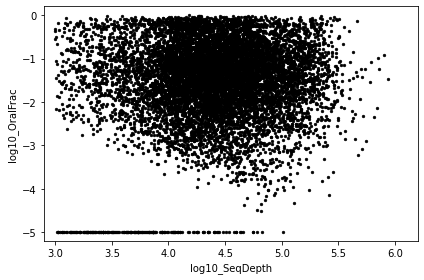

In [64]:
# compute sequence depth
df_count_sum = pd.merge(df_oral_total, df_count_stacked.sum(axis=1).to_frame().rename({0:'SeqDepth'}, axis=1), left_index=True, right_index=True, how='inner')
df_count_sum = df_count_sum.rename({'OralFrac_HMPv35oral':'OralFrac'}, axis=1)
df_count_sum['Detected'] = (df_count_sum.OralFrac>0).astype(str)
df_count_sum.loc[df_count_sum.OralFrac==0,'OralFrac'] = 1e-5
df_count_sum['log10_SeqDepth'] = np.log10(df_count_sum['SeqDepth'])
df_count_sum['log10_OralFrac'] = np.log10(df_count_sum['OralFrac'])

# spearman correlation
print(spearmanr(df_count_sum.log10_SeqDepth, df_count_sum.log10_OralFrac))
print(kendalltau(df_count_sum.log10_SeqDepth, df_count_sum.log10_OralFrac))

fig, ax = plt.subplots(figsize=(6,4))

_ = sns.scatterplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, s=32, color='k', edgecolor='k', marker='.')
_ = ax.set_ylim([-5.2,0.2])
_ = ax.set_xlim([2.9,6.2])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatterplot_depth_vs_oral_fraction.svg", dpi=600, bbox_inches='tight')